In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.dpi'] = 200

In [3]:
# define constants in SI units
G = 6.67430e-11 # m^3 kg^-1 s^-2
kB = 1.38064852e-23 # m^2 kg s^-2 K^-1
m_H = 1.6737236e-27 # kg

m_Earth = 5.972e24 # kg
r_Earth = 6.371e6 # m
rho_Earth = m_Earth / (4/3 * np.pi * r_Earth**3) # kg m^-3
print('Earth')
print(rho_Earth*1e-3, 'g/cm^3')

# Galilean Moons
moon_names = ['Io', 'Europa', 'Ganymede', 'Callisto']
m_galilean_moons = np.array([8.93e22, 4.8e22, 1.48e23, 1.08e23]) # kg
r_galilean_moons = np.array([1821.6e3, 1560.8e3, 2634.1e3, 2410.3e3]) # m
rho_galilean_moons = m_galilean_moons / (4/3 * np.pi * r_galilean_moons**3) # kg m^-3
print(moon_names)
print(rho_galilean_moons*1e-3, 'g/cm^3')

Earth
5.513258738589093 g/cm^3
['Io', 'Europa', 'Ganymede', 'Callisto']
[3.5269865  3.01377523 1.93319797 1.84128851] g/cm^3


### Thermal Escape (Hydrostatic)

Criterion from Seager (2010), Eq. 4.50:

$ \sqrt{\frac{2 k_\mathrm{B} T_\mathrm{exo}}{\mu m_\mathrm{H}}} > \frac{1}{6} \sqrt{\frac{2 G M_\mathrm{P}}{R_\mathrm{P}}} $

Resulting maximum Temperature (for stability):

$ T_\mathrm{exo,max} = \frac{1}{36} \frac{\mu m_\mathrm{H}}{k_\mathrm{B}} \frac{G M_\mathrm{P}}{R_\mathrm{P}} $

In [4]:
# Define Planet and Atmospheric Composition

m_P = 1.0 * m_Earth
r_P = 1.0 * r_Earth
g_P = G*m_P/(r_P**2)
mu = 1.008 # mean molecular weight in amu

def maxTexo(m_P, r_P, mu):
    return mu * m_H * G * m_P / (36 * kB * r_P)

TmaxExo = maxTexo(m_P, r_P, mu)
print(f"Maximum Exospheric Temperature for Earth: {TmaxExo:.2f} K")

# for Galilean Moons:
TmaxExo = maxTexo(m_galilean_moons, r_galilean_moons, mu)
for i, moon in enumerate(moon_names):
    print(f"Maximum Exospheric Temperature for {moon}: {TmaxExo[i]:.2f} K")

Maximum Exospheric Temperature for Earth: 212.36 K
Maximum Exospheric Temperature for Io: 11.11 K
Maximum Exospheric Temperature for Europa: 6.97 K
Maximum Exospheric Temperature for Ganymede: 12.73 K
Maximum Exospheric Temperature for Callisto: 10.15 K


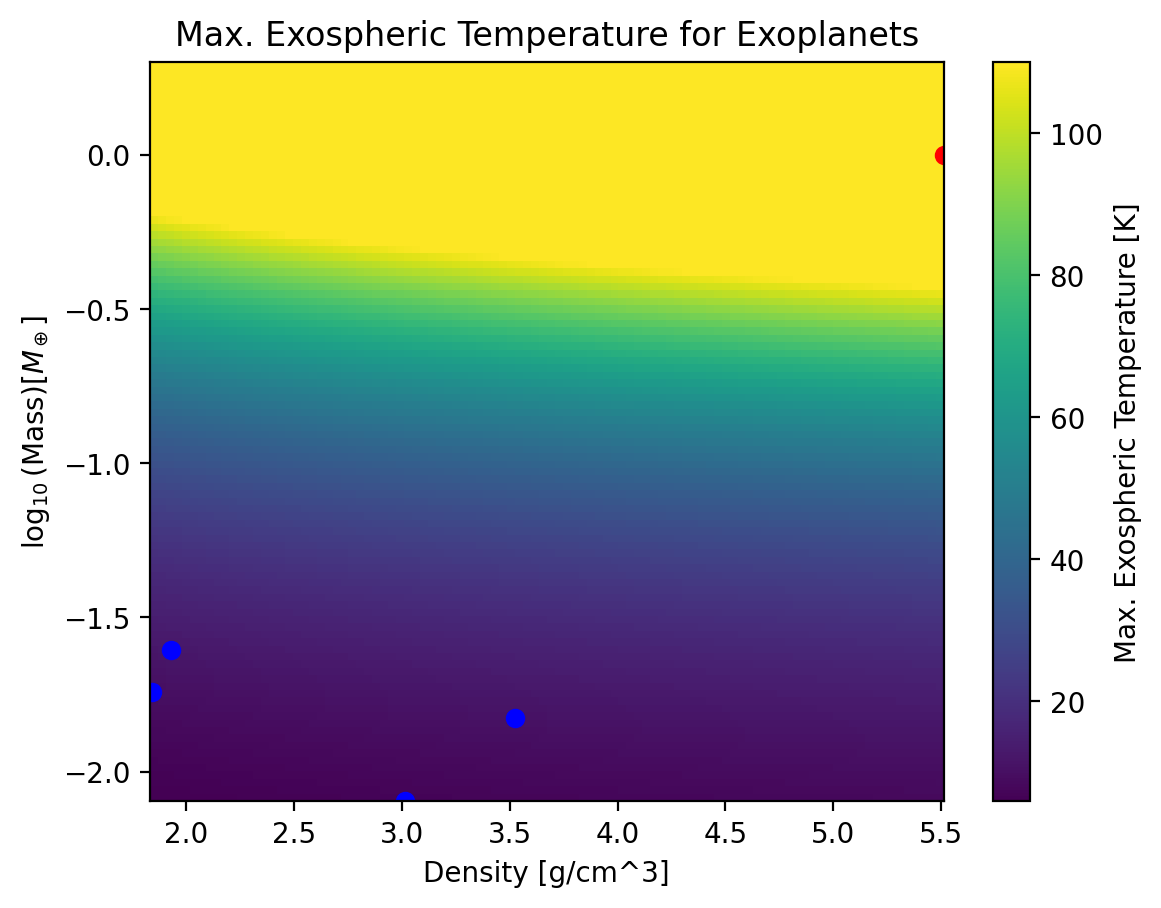

In [5]:
densitiy_range = [1.834, 5.51] # Least Dense Galilean Moon (Callisto): 1.834 g/cm^3, Avg. Earth: 5.51 g/cm^3
densities = np.linspace(densitiy_range[0], densitiy_range[1], 100) * 1e3 # kg/m^3

mass_range = [0.008, 2.0] # Least Massive Galilean Moon (Europa): 0.008 M_Earth
masses = np.logspace(np.log10(mass_range[0]), np.log10(mass_range[1]), 100) * m_Earth # kg

densities, masses = np.meshgrid(densities, masses)

# calculate the radii of the planets
radii = (3 * masses / (4 * np.pi * densities))**(1/3)

# calculate the exospheric temperatures
TmaxExo = maxTexo(masses, radii, mu)

# plot with imshow
plt.imshow(TmaxExo, extent=[densitiy_range[0], densitiy_range[1], np.log10(mass_range[0]), np.log10(mass_range[1])], \
           aspect='auto', origin='lower', vmax=110)

plt.colorbar(label='Max. Exospheric Temperature [K]')

plt.plot(rho_Earth*1e-3, 0.0, 'o', c='red', label='Earth')
plt.plot(rho_galilean_moons*1e-3, np.log10(m_galilean_moons/m_Earth), 'o', c='blue', label='Galilean Moons')
#plt.legend()

plt.xlim(densitiy_range)
plt.xlabel('Density [g/cm^3]')
plt.ylabel(r'$\log_{10}(\mathrm{Mass}) [M_\oplus]$')
plt.title('Max. Exospheric Temperature for Exoplanets')
plt.show()

### Exobase

Calculate the location $r_c$ and properties of the Exobase:

Mean Free Path > Atmospheric Scale Height

$ \frac{1}{\sqrt{2} \pi d^2 n(r_\mathrm{c})} > \frac{k_\mathrm{B} T(r_\mathrm{c})}{\mu m_\mathrm{H} g(r_\mathrm{c})} $

$ r_\mathrm{c} = \sqrt{ \frac{G}{\sqrt{2} \pi} \frac{\mu m_\mathrm{H} M_\mathrm{P}}{d^2} \frac{1}{P(r_\mathrm{c})} } $

In [6]:
kin_dia = 289e-12 # H2 (see Wikipedia: Kinetic Diameter)

def r_exobase(press, m_P, mu, kin_dia):
    r_c = G / (np.sqrt(2) * np.pi)
    r_c *= mu * m_H * m_P / (kin_dia**2 * press)
    r_c = np.sqrt(r_c)
    return r_c

3.441860428328995e-07


(0.0, 5000000.0)

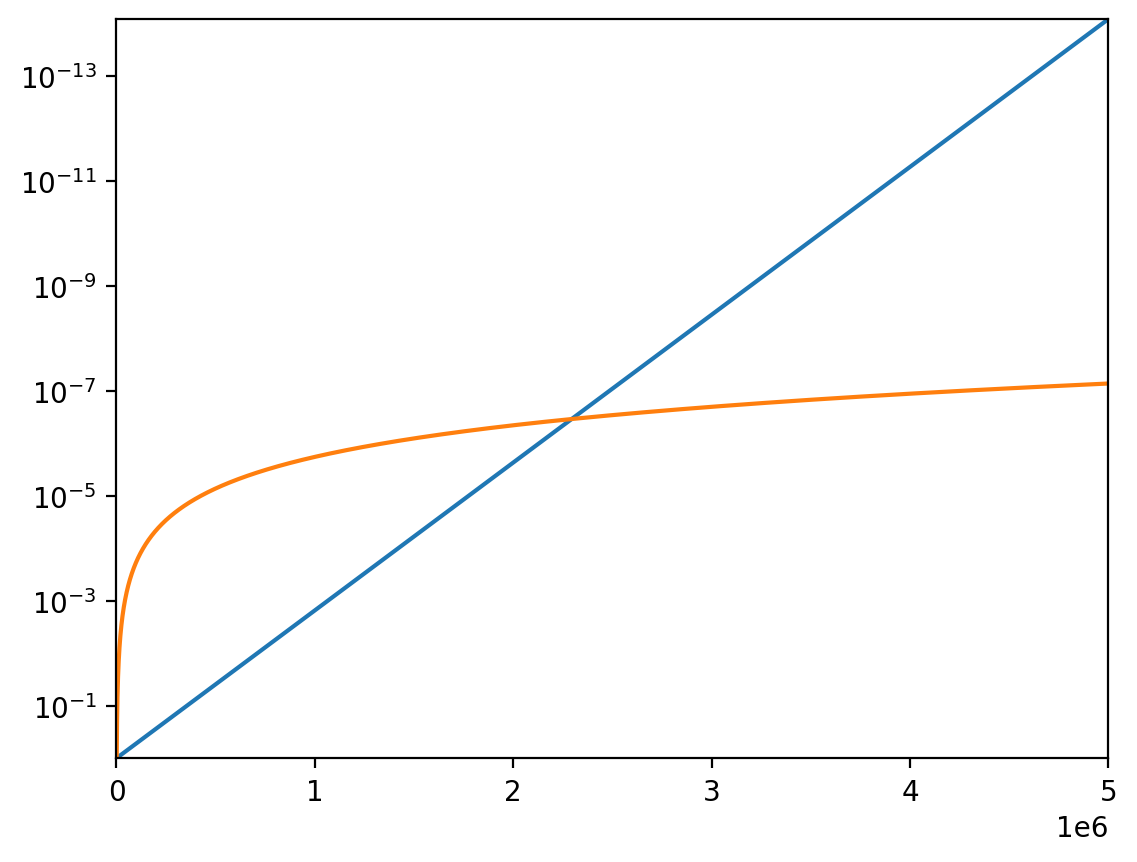

In [61]:
# example isothermal atmosphere

def pressure_profile(h, T, g, mu, P0=1.0):
    return P0 * np.exp(- g*h*mu*m_H / (T*kB))

T_atmo = 185
h = np.linspace(0, 5e6, 100000)

Ps = pressure_profile(h, T_atmo, g_P, mu, P0=1)
r_c = r_exobase(Ps, m_P, mu, kin_dia)

mask = Ps < 0.9*Ps[0]
print(Ps[mask][r_c[mask] > h[mask]][0])

plt.plot(h, Ps)
plt.plot(r_c, Ps)
plt.yscale('log')
plt.ylim(Ps[0], Ps[-1])
plt.xlim(h[0], h[-1])

### Jeans Escape

$ \Phi_\mathrm{Jeans} = \frac{n_\mathrm{c}}{2\sqrt{\pi}} B \sqrt{\frac{2 k_\mathrm{B} T_\mathrm{c}}{\mu m_\mathrm{H}}} \left( 1 + \lambda_\mathrm{c} \right) \mathrm{e}^{-\lambda_\mathrm{c}} $

$ \lambda_\mathrm{c} = \frac{G M_\mathrm{P} \mu m_\mathrm{H}}{k_\mathrm{B} T_\mathrm{c} r_\mathrm{c}} = \frac{r_\mathrm{c}}{H} $

with subscript "c" for exobase and $B \approx 0.5 - 0.8$.

In [62]:
# calculate the Jeans escape rate

def escape_rate(r_c, P_c, T_c, m_P, mu, B=0.65):
    lambda_c = G * m_P * mu * m_H / (kB * T_c * r_c)
    n_c = P_c / (kB * T_c)
    phi_jeans = n_c / (2 * np.sqrt(np.pi)) * B
    phi_jeans *= np.sqrt(2 * kB * T_c / (mu * m_H))
    phi_jeans *= (1 + lambda_c) * np.exp(-lambda_c)
    return phi_jeans

# if r_c is an array
if len(r_c.shape):
    mask = Ps < 0.9*Ps[0]
    i_c = np.arange(len(Ps))[mask][r_c[mask] > h[mask]][0]
    r_c = r_c[i_c]
    P_c = Ps[i_c]
    T_c = T_atmo

phi_jeans = escape_rate(r_c, P_c, T_c, m_P, mu)
print(phi_jeans, 'm^-2 s^-1')

phi_jeans_tot = phi_jeans * 4 * np.pi * r_c**2
print(phi_jeans_tot, 's^-1')

escape_time = 1 / phi_jeans_tot
escape_time_yrs = escape_time / (60*60*24*365.25)
print(f'{escape_time_yrs:.2e} years')

7.359539638105904e-32 m^-2 s^-1
4.8694117145410795e-18 s^-1
6.51e+09 years
